In [23]:
import matplotlib.pyplot as plt

In [27]:
class BayesianInference:
    # Konstruktor klasy
    def __init__(self):
        """Zbiór wszystkich prawdopodobieństw"""
        self.probabilities = {}

    # Metoda ustawiania prawdopodobieństwa
    def set_probability(self, event, given, value):
        """Przykład: p(b|I) = value -> set_probability('b', 'I', value)"""
        self.probabilities[(event, given)] = value

    # Metoda dostępu do wartości prawdopodobieństw
    def get_probability(self, event, given=None):
        """Przykład: get_probability('b', 'I') -> p(b|I). Jeśli 'given' is None -> p(b)."""
        if given is not None:
            if self.probabilities.get((event, given), None) is None:
                reverse_prob = self.probabilities.get((given, event), None)
                marginal_event = self.probabilities.get((event, None), None)
                marginal_given = self.probabilities.get((given, None), None)
                if reverse_prob is not None and marginal_event is not None and marginal_given is not None:
                    prob = (reverse_prob * marginal_event) / marginal_given
                    self.set_probability(event, given, prob)
                    return prob
                else:
                    return None
            return self.probabilities.get((event, given), None)
        else:
            return self.probabilities.get((event, None), None)

    # Metoda obliczania prawdopodobieństw z wielu dowodów
    def calculate_posterior(self, target, evidence):
        """Przykład: p(I|a,b) = (p(a|I) * p(b|I) * p(I)) / (p(I) * p(a,b|I) + p(~I) * p(a,b|~I))"""
        # Krok 1: Obliczamy p(a,b|I) = p(a|I) * p(b|I)
        pab_I = self.calculate_joint_probability(target, evidence, given_target=True)

        # Krok 2: Obliczamy p(~I)
        pI = self.get_probability(target)
        pnI = 1 - pI

        # Krok 3: Obliczamy p(a|~I) i p(b|~I)
        marginal_probs = {}
        for ev in evidence:
            pa = self.get_probability(ev)  # p(a)
            pa_I = self.get_probability(ev, target)  # p(a|I)
            pa_nI = (pa - pI * pa_I) / pnI  # p(a|~I)
            marginal_probs[ev] = pa_nI

        # Krok 4: Obliczamy p(a,b|~I) = p(a|~I) * p(b|~I)
        pab_nI = 1
        for ev in evidence:
            pab_nI *= marginal_probs[ev]

        # Krok 5: Obliczamy p(I|a,b)
        numerator = pab_I * pI
        denominator = pI * pab_I + pnI * pab_nI

        return numerator / denominator

    def calculate_joint_probability(self, target, evidence, given_target=False):
        """
        Oblicza wspólne prawdopodobieństwo p(a,b|I) lub p(a,b|~I), w zależności od parametru 'given_target'.
        """
        joint_prob = 1  # Zaczynamy od neutralnego iloczynu
        for ev in evidence:
            if given_target:
                # Obliczamy p(ev|target)
                p_ev_given_target = self.get_probability(ev, target)
                if p_ev_given_target is None:
                    raise ValueError(f"Brak możliwości obliczenia p({ev}|{target})")
                joint_prob *= p_ev_given_target
            else:
                # Obliczamy p(ev)
                p_ev = self.get_probability(ev)
                if p_ev is None:
                    raise ValueError(f"Brak możliwości obliczenia p({ev})")
                joint_prob *= p_ev
        return joint_prob


In [28]:
bayesian = BayesianInference()
bayesian.set_probability('I', None, 0.002)  # p(I)
bayesian.set_probability('a', 'I', 0.8)  # p(a|I)
bayesian.set_probability('b', 'I', 0.98)  # p(b|I)
bayesian.set_probability('a', None, 0.01)  # p(a)
bayesian.set_probability('b', None, 0.5)  # p(b)

#Obliczanie p(I|a,b)
posterior = bayesian.calculate_posterior('I', ['a', 'b'])
print(f"Prawdopodobieństwo p(I|a,b): {posterior}")


Prawdopodobieństwo p(I|a,b): 0.27222601071602537


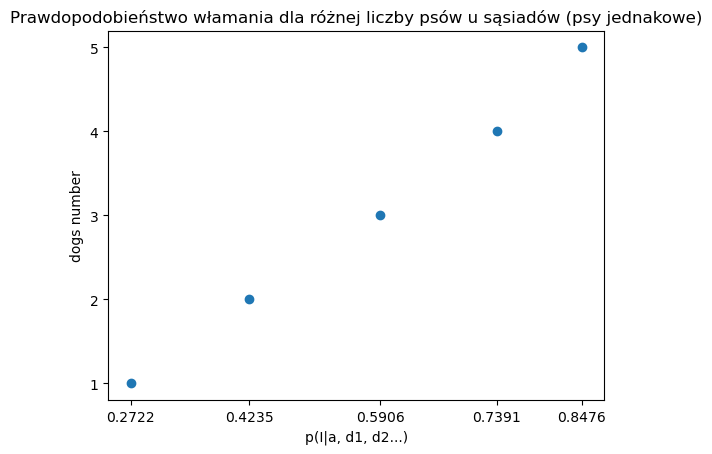

In [29]:
posteriors = []
dogs_number = [1, 2, 3, 4, 5]
evidence = ['a']

bayesian = BayesianInference()
bayesian.set_probability('I', None, 0.002)  # p(I)
bayesian.set_probability('a', 'I', 0.8)     # p(a|I)
bayesian.set_probability('a', None, 0.01)   # p(a)

for d_num in dogs_number:
    bayesian.set_probability(f'd{d_num}', 'I', 0.98)
    bayesian.set_probability(f'd{d_num}', None, 0.5)
    evidence.append(f'd{d_num}')
    posteriors.append(bayesian.calculate_posterior('I', evidence))

plt.title('Prawdopodobieństwo włamania dla różnej liczby psów u sąsiadów (psy jednakowe)')
plt.scatter(posteriors, dogs_number)
plt.xlabel('p(I|a, d1, d2...)')
plt.ylabel('dogs number')
plt.yticks(dogs_number)
plt.xticks(posteriors)
plt.show()

In [ ]:
#W sytuacji gdy alarm sygnalizuje światłem i dźwiękiem, że wykrył włamanie nie można zastosować tego samego podejścia
#co w przypadku gdy alarm jedynie wysyła komunikat na telefon. W nowym przypadku alarm może doprowadzić do tego,
#że pies sąsiada zacznie szczekać, a więc pies niekoniecznie sam wykryje włamanie. W tej sytuacji mamy doczynienia z
#prawdopodobieństwem zależnym.